In [12]:
pip install pandarallel

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [13]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
import spacy
import os
import multiprocessing
import gc
import io
import spacy

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from pandarallel import pandarallel
from wordcloud import WordCloud

from nltk import word_tokenize,pos_tag
from nltk.corpus import stopwords

from collections import Counter
from tqdm import tqdm
from wordcloud import WordCloud
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import TweetTokenizer

tqdm.pandas()
cores = multiprocessing.cpu_count()

pandarallel.initialize()
tqdm(pandarallel)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

0it [00:00, ?it/s]

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
/kaggle/input/quora/sample_submission.csv
/kaggle/input/quora/train.csv
/kaggle/input/quora/test.csv


In [14]:
train = pd.read_csv('../input/quora/train.csv')
test = pd.read_csv('../input/quora/test.csv')

0    735222
1     48451
Name: target, dtype: int64


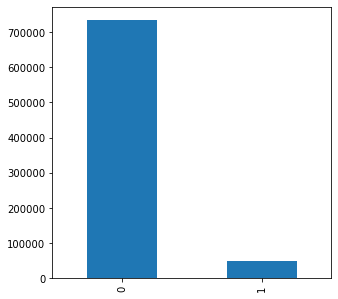

In [15]:
plt.subplots(figsize = (5, 5))
count_target = train['target'].value_counts()
print(count_target)
count_target.plot.bar()

,qid,question_text,target,tokens,num_tokens,num_of_sentence
437309,f53077f4d81f009e8297,What are some examples of silicon nanophotonics?,0,"(What, are, some, examples, of, silicon, nanop...",8,1
17420,8604945b985f80508ff2,Will Buddysbook be a next social site?,0,"(Will, Buddysbook, be, a, next, social, site, ?)",8,1
231402,da47eb5709970fa179dc,How did the bhakti tradition begin?,0,"(How, did, the, bhakti, tradition, begin, ?)",7,1
387371,be80b74c376c028e7e30,Whatare top 2 important essays for 8 class?,0,"(Whatare, top, 2, important, essays, for, 8, c...",9,1
623572,fd4bb983d06fd1a91313,How can I change my business page name on Face...,0,"(How, can, I, change, my, business, page, name...",12,1


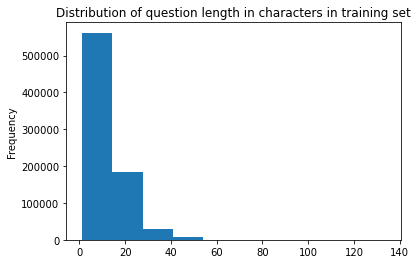

In [16]:
plt.yscale('linear');
plt.title('Distribution of question length in characters in training set')
train['question_text'].apply(lambda y: len(y.split())).plot(kind = 'hist');
copy_data = train.sample(n = 10000)
nlp = spacy.load('en')
copy_data['tokens'] = [nlp(text, disable = ['ner', 'tagger','textcat']) for text in copy_data['question_text']]
copy_data.sample(5)
copy_data['num_tokens'] = [len(token) for token in copy_data['tokens']]
sentences = [list(i.sents) for i in copy_data['tokens']]
copy_data['num_of_sentence'] = [len(i) for i in sentences]

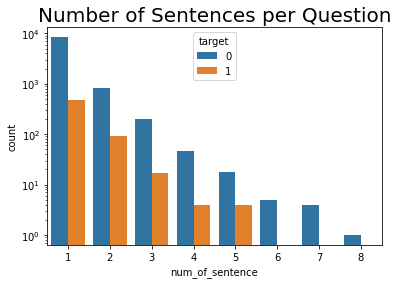

In [17]:
fig, ax = plt.subplots()
g = sns.countplot(copy_data['num_of_sentence'], hue = copy_data['target'])
plt.title('Number of Sentences per Question', fontsize = 20)
ax.set(yscale = 'log')
plt.show()

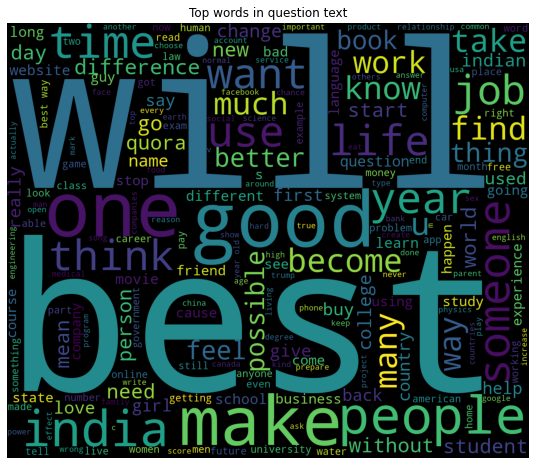

In [18]:
text = ' '.join(copy_data[copy_data['target'] == 0].question_text.str.lower().values[-1000000:])
wordcloud = WordCloud(max_font_size = None, background_color = 'black', width = 1200, height = 1000).generate(text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.title('Top words in question text')
plt.axis("off")
plt.show()

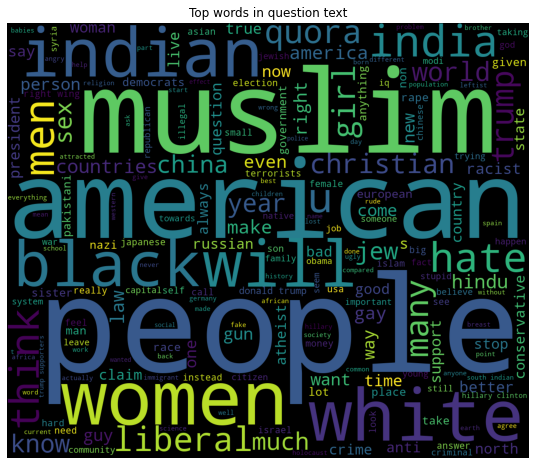

In [19]:
text = ' '.join(copy_data[copy_data['target'] == 1].question_text.str.lower().values[-1000000:])
wordcloud = WordCloud(max_font_size = None, background_color = 'black', width = 1200, height = 1000).generate(text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.title('Top words in question text')
plt.axis("off")
plt.show()

In [20]:
qid = test.qid
y = train.target
train = train.drop(['target'], axis =1)

In [21]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(train, y, test_size = 0.1, shuffle = True, random_state = 2020, stratify = y)

In [22]:
puncts = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

def clean_text(x):
    x = str(x)
    
    for punct in punct_mapping:
        x = x.replace(punct, punct_mapping[punct])
    
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
        
    return x

def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 'pokémon': 'pokemon',"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispellings, mispellings_re = _get_mispell(mispell_dict)

def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]
    return mispellings_re.sub(replace, text)

def text_cleaning(text):
    text = replace_typical_misspell(text)
    text = clean_text(text)
    text = clean_numbers(text)
    return text

def text_clean_wrapper(df):
    df["question_text"] = df["question_text"].parallel_apply(text_cleaning)
    return df

train_x = text_clean_wrapper(train_x)
valid_x = text_clean_wrapper(valid_x)
test = text_clean_wrapper(test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
all_text = train_x['question_text']
all_text = all_text.append(valid_x['question_text'])
all_text = all_text.append(test['question_text'])

tfidf = TfidfVectorizer(strip_accents = 'unicode', stop_words = 'english', ngram_range = (1,3), max_features = 33000, token_pattern = r'\w{1,}', min_df = 3,
                        max_df = 0.9, analyzer = 'word')

tfidf.fit(all_text)

train_word = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(train_x['question_text']))
valid_word = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(valid_x['question_text']))
test_word = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(test['question_text']))

In [24]:
tfidf_char = TfidfVectorizer(ngram_range = (1, 4), max_df = 0.9, strip_accents = 'unicode', use_idf = True, smooth_idf = True, sublinear_tf = True,
                             max_features = 25000, analyzer = 'char')

tfidf_char.fit(all_text)

train_char = pd.DataFrame.sparse.from_spmatrix(tfidf_char.transform(train_x['question_text']))
valid_char = pd.DataFrame.sparse.from_spmatrix(tfidf_char.transform(valid_x['question_text']))
test_char = pd.DataFrame.sparse.from_spmatrix(tfidf_char.transform(test['question_text']))

In [25]:
train = pd.concat([train_word, train_char], axis = 1, ignore_index = True, sort = False)
valid = pd.concat([valid_word, valid_char], axis = 1, ignore_index = True, sort = False)
test = pd.concat([test_word, test_char], axis = 1, ignore_index = True, sort = False)

In [26]:
class Vt:
    def __init__(self, estimators):
        self.estimators = estimators
        
    def fit(self, train, target):
        for model in self.estimators:
            model[1].fit(train, target)
    def predict_proba(self, test, weights):
        predictions = np.array([0.0]*len(test))
        weights = np.array(weights)
        weights /= np.sum(weights)
        for i in range(weights.shape[0]):
            predictions += weights[i]*self.estimators[i][1].predict_proba(test)[ : , 1]
        return predictions

In [27]:
sgd = SGDClassifier(alpha = 0.0001, max_iter = 1000, penalty = "l2", loss = 'modified_huber', verbose = 5, random_state = 2020)
logit = LogisticRegression(penalty = 'l2', max_iter = 200, fit_intercept = True, solver = 'liblinear', multi_class = 'ovr', random_state = 2020)
logit1 = BernoulliNB(binarize = 0.2)
rfc = RandomForestClassifier(verbose = 5, criterion = 'entropy', max_depth = 100, max_features = 5000, n_estimators = 20, n_jobs = cores , min_samples_leaf = 3, 
                             min_samples_split = 10)

vt = Vt(estimators = [('sgd', sgd), ('logit', logit), ('bn', logit1), ('rfc', rfc)])
vt.fit(train, train_y)

y = 0.27
y_pred = vt.predict_proba(train, weights = [1.1, 3, 0.084, 1.09])
y_pred = (y_pred > y).astype(np.int)
accuracy_score(train_y, y_pred)

-- Epoch 1
Norm: 16.35, NNZs: 56908, Bias: -1.742402, T: 705305, Avg. loss: 0.163114
Total training time: 0.63 seconds.
-- Epoch 2
Norm: 15.69, NNZs: 57378, Bias: -1.613154, T: 1410610, Avg. loss: 0.133375
Total training time: 1.27 seconds.
-- Epoch 3
Norm: 15.46, NNZs: 57471, Bias: -1.556887, T: 2115915, Avg. loss: 0.132008
Total training time: 1.90 seconds.
-- Epoch 4
Norm: 15.41, NNZs: 57523, Bias: -1.521319, T: 2821220, Avg. loss: 0.131477
Total training time: 2.53 seconds.
-- Epoch 5
Norm: 15.32, NNZs: 57537, Bias: -1.502028, T: 3526525, Avg. loss: 0.131153
Total training time: 3.15 seconds.
-- Epoch 6
Norm: 15.25, NNZs: 57549, Bias: -1.489504, T: 4231830, Avg. loss: 0.130922
Total training time: 3.78 seconds.
-- Epoch 7
Norm: 15.25, NNZs: 57551, Bias: -1.473904, T: 4937135, Avg. loss: 0.130820
Total training time: 4.39 seconds.
-- Epoch 8
Norm: 15.23, NNZs: 57555, Bias: -1.463311, T: 5642440, Avg. loss: 0.130698
Total training time: 5.02 seconds.
Convergence after 8 epochs took 5

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 32.3min


building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=4)]: Done  18 out of  20 | elapsed: 53.7min remaining:  6.0min
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed: 54.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done  18 out of  20 | elapsed:    4.5s remaining:    0.5s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    4.8s finished


0.9655156279907274

In [28]:
y_pred = vt.predict_proba(valid, weights = [1.1, 3, 0.084, 1.09])
y_pred = (y_pred > y).astype(np.int)

print(precision_score(valid_y, y_pred))
print(f1_score(valid_y, y_pred))
print(recall_score(valid_y, y_pred))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.3s


0.6106623586429726
0.653225806451613
0.7021671826625387


[Parallel(n_jobs=4)]: Done  18 out of  20 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.6s finished


In [29]:
final_y = vt.predict_proba(test, weights = [1.1, 3, 0.084, 1.09])
final_y = (final_y > y).astype(np.int)
final_y = pd.DataFrame(final_y)
final_y['target'] = final_y[0]
final_y.drop([0], axis = 1, inplace = True)
final_y['qid'] = qid
final_y.to_csv('submission.csv', index = False)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done  18 out of  20 | elapsed:    3.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    3.5s finished
